In [1]:
%matplotlib inline
from matplotlib import style
style.use('bmh')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st

In [3]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

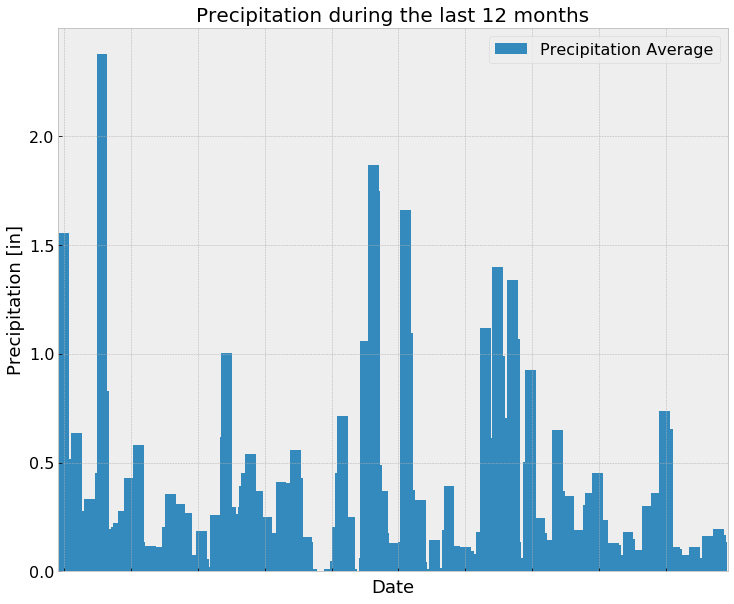

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the first date recorded
session.query(Measurement.date).order_by(Measurement.date).first()

# Find the last date recorded
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# last_date

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d')-dt.timedelta(days=365)
# last_year

# Perform a query to retrieve the data and precipitation scores
prcp_dates = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_year).\
                    group_by(Measurement.date).all()
# prcp_dates

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(prcp_dates, columns = ['Date', 'Precipitation Average'])
precipitation.set_index('Date', inplace=True)
precipitation.head()

# Sort the dataframe by date
precipitation = precipitation.sort_values(by = 'Date')
# precipitation.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation.plot(kind = 'bar', width=6, figsize=(12,10))
plt.locator_params(axis='x', nbins=10)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(1,1), fontsize="16")
plt.title("Precipitation during the last 12 months", size=20)
plt.ylabel("Precipitation [in]", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Precipitation.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation Average
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

('USC00519281', 2772)

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
most_active = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [16]:
most_active

'USC00519281'

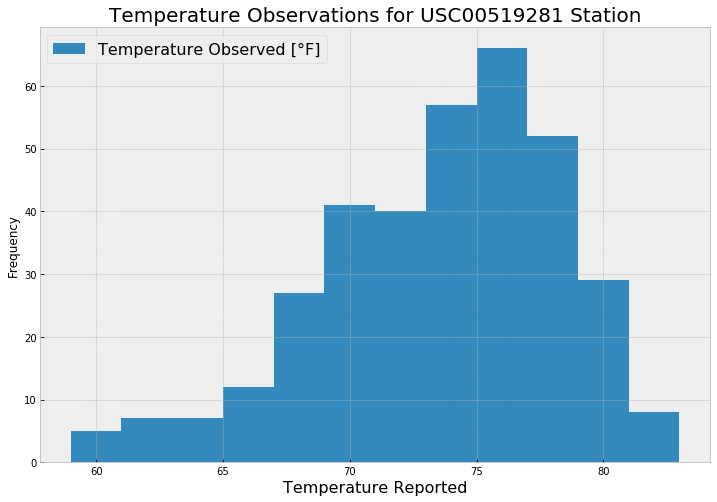

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_dates = session.query(Measurement.date, func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active).\
                    filter(Measurement.date >= last_year).\
                    group_by(Measurement.date).all()
# tobs_dates

# Save the query results as a Pandas DataFrame
tobs = pd.DataFrame(tobs_dates, columns = ['Date', 'Temperature Observed [°F]'])
tobs.set_index('Date', inplace = True)
# tobs.head()

# Histogram plot
tobs.plot.hist(bins = 12, figsize= (12, 8))
plt.title(f'Temperature Observations for {most_active} Station', fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(0.44,1), fontsize=16)
plt.savefig("MostActiveTemps.png")
plt.show()


## Bonus Challenge Assignment

### Temperature Analysis I

In [19]:
# Create a dataframe with the temperatures from each station across all available years in june and calculate the mean
tobs_june = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == "06").\
                    group_by(Measurement.date).all()
# tobs_june

june = pd.DataFrame(tobs_june, columns = ['Date', 'Station', 'Temperature'])
june = june.groupby(['Station'])['Temperature'].mean().reset_index()
# june

# Create a dataframe with the temperatures from each station across all available years in december and calculate the mean
tobs_dec = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
                    filter(func.strftime("%m", Measurement.date) == "12").\
                    group_by(Measurement.date).all()
# tobs_dec

dec = pd.DataFrame(tobs_dec, columns = ['Date', 'Station', 'Temperature'])
dec = dec.groupby(['Station'])['Temperature'].mean().reset_index()
# dec

# Compare using an unpaired t-test (they are different groups)
st.ttest_ind(june['Temperature'], dec['Temperature'])

Ttest_indResult(statistic=2.0927210579032125, pvalue=0.17145012575192545)

### Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacations = calc_temps('2016-11-28', '2016-12-13')
print(f'The minimum, average and maximum temperatures during your last years time for your vacations are: {vacations}')

The minimum, average and maximum temperatures during your last years time for your vacations are: [(65.0, 71.43809523809524, 78.0)]


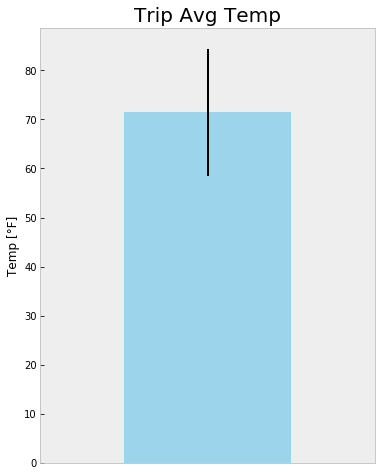

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacations_df = pd.DataFrame(vacations, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg = vacations_df['Avg Temp']
m_temp = vacations_df.iloc[0]['Max Temp'] - vacations_df.iloc[0]['Min Temp']
avg.plot(kind='bar', yerr=m_temp, figsize=(6,8), alpha=0.8, color='skyblue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp [°F]")
plt.xticks([])
plt.grid()
plt.savefig("Vacations.png")
plt.show()

### Daily Rainfall Average

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Query for precipitation data per station for last year
precipitation = session.query(Measurement.station, Measurement.prcp,).\
                    filter(Measurement.date >= last_year).all()

# Query for station properties
precipitation_coords = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation, Station.station).all()

# Dataframe for precipitation data per station for last year
prcp1 = pd.DataFrame(precipitation, columns = ['Station', 'Precipitation'])
prcp1 = prcp1.groupby('Station').sum().reset_index()[['Station', 'Precipitation']].sort_values(by = 'Station')
# prcp1.head(10)

# Dataframe for station properties
prcp2 = pd.DataFrame(precipitation_coords, columns = ['Name', 'Lat', 'Lng', 'Elevation', 'Station']).sort_values(by = 'Station')
# prcp2.head(10)

# Merge station properties and precipitation per station data
prcp_df = pd.merge(prcp2, prcp1, how = 'left')
prcp_df = prcp_df[['Station', 'Name', 'Lat', 'Lng', 'Elevation', 'Precipitation']].sort_values(by = 'Precipitation', ascending = False)
prcp_df.head(10)

,Station,Name,Lat,Lng,Elevation,Precipitation
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.11
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,68.24
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.36
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,37.99
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.19
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
full_date = []
calculated = []

# Create a function to create a list of tuples for the vacation dates
def daterange(date1, date2):
    
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

# Set the start and end date of the trip
start_dt = date(2016, 11, 28)
end_dt = date(2016, 12, 13)

# Use the start and end date to create a range of dates for the vacation and for the data frame
for dt in daterange(start_dt, end_dt):
    # Stip off the year and save a list of %m-%d strings
    normals.append(dt.strftime("%m-%d"))
    full_date.append(dt.strftime("%Y-%m-%d"))
# normals

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in normals:
    calculated.append(daily_normals(i)[0])

# print(calculated)           

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(calculated, columns = ['TMin', 'TAvg', 'TMax'], index = (full_date))
normals_df.head()

,TMin,TAvg,TMax
2016-11-28,62.0,72.755102,80.0
2016-11-29,62.0,71.019608,79.0
2016-11-30,61.0,71.807692,79.0
2016-12-01,65.0,71.916667,78.0
2016-12-02,62.0,71.326923,77.0


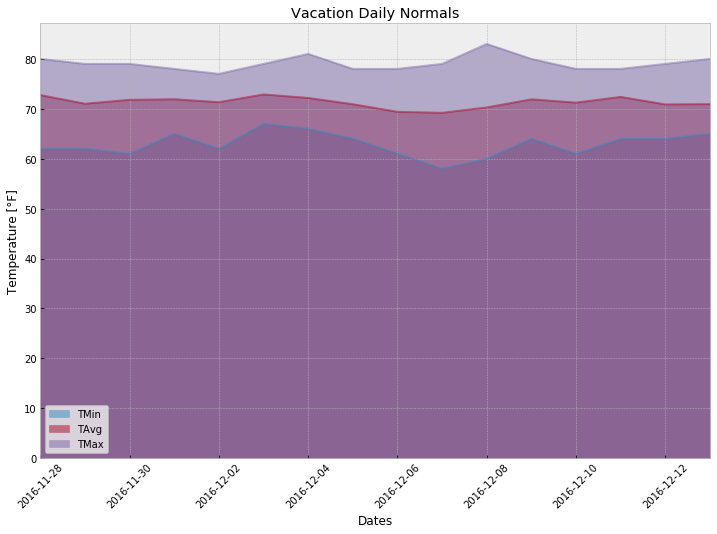

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
ax3 = normals_df.plot.area(stacked=False, figsize = (12,8), alpha = 0.5)
plt.title('Vacation Daily Normals')
plt.xlabel('Dates')
plt.ylabel('Temperature [°F]')
plt.xticks(rotation = 45)
plt.savefig("DailyNormals.png")
plt.show()